# Clustering Unlabeled Sound Data

# Sound Clustering Assignment
This notebook covers feature extraction, dimensionality reduction, and clustering of an unlabeled sound dataset.

In [2]:
# Data Loading and Feature Extraction
import zipfile, os
import librosa
import numpy as np
import pandas as pd

zip_path = 'unlabelled_sounds.zip'
extract_dir = 'unlabelled_sounds'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

def extract_mel_spectrogram(file_path, sr=22050, n_mels=128):
    y, _ = librosa.load(file_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S.mean(axis=1)

features, file_names = [], []
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith('.wav') or file.endswith('.mp3'):
            file_path = os.path.join(root, file)
            feature = extract_mel_spectrogram(file_path)
            features.append(feature)
            file_names.append(file)

X = pd.DataFrame(features)
X['filename'] = file_names
X_features = X.drop('filename', axis=1)

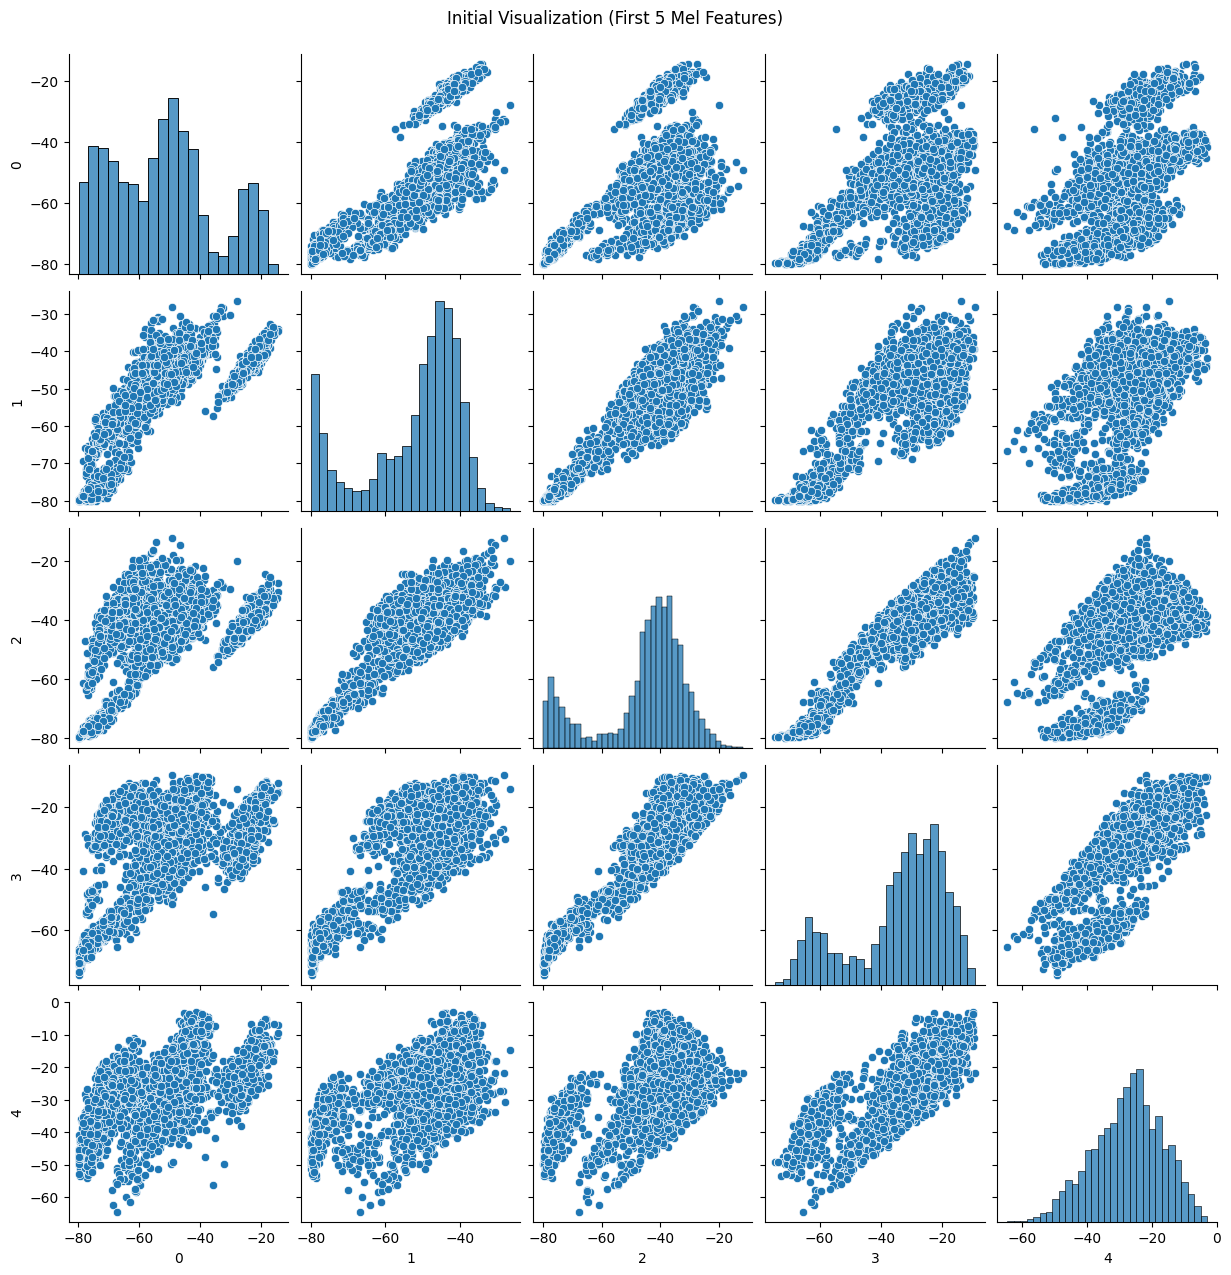

In [3]:
# Initial Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(X_features.iloc[:, :5])
plt.suptitle("Initial Visualization (First 5 Mel Features)", y=1.02)
plt.show()

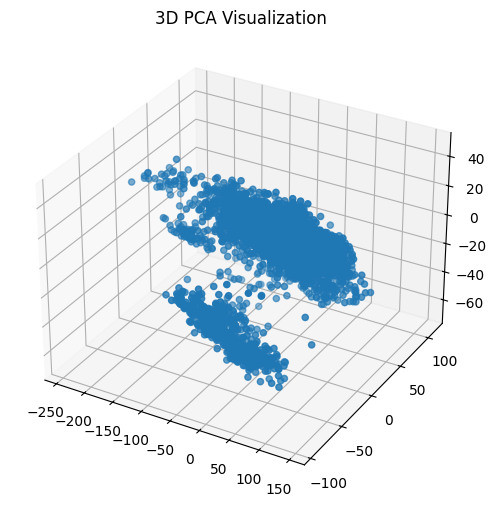

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


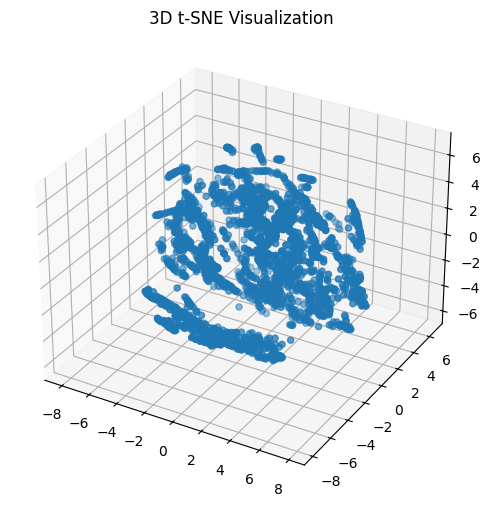

In [4]:
# PCA and t-SNE Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_features)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
plt.title("3D PCA Visualization")
plt.show()

tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_features)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2])
plt.title("3D t-SNE Visualization")
plt.show()

### Why is dimensionality reduction important?

### Why is Dimensionality Reduction Important?
Attempting to visualize high-dimensional audio features without dimensionality reduction quickly leads to cluttered and unintelligible scatter plots. Many data points overlap or show no clear separation, especially when dimensions exceed three. This is because human perception and most 2D/3D plotting tools cannot effectively represent relationships in high-dimensional space. Moreover, Mel features are interdependent, making it hard to detect cluster tendencies without reducing noise and redundancy.

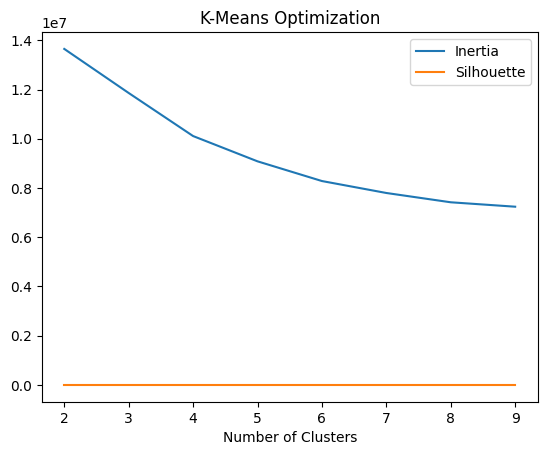

In [5]:
# Clustering and Evaluation
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertia, silhouette = [], []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_features)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_features, labels))

plt.plot(range(2, 10), inertia, label='Inertia')
plt.plot(range(2, 10), silhouette, label='Silhouette')
plt.xlabel("Number of Clusters")
plt.legend()
plt.title("K-Means Optimization")
plt.show()

optimal_k = silhouette.index(max(silhouette)) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_labels = kmeans.fit_predict(X_features)
dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_features)

### Which method (PCA or t-SNE) provides better separability of clusters and why?

### PCA vs t-SNE
t-SNE tends to show clearer separations among clusters compared to PCA, especially in non-linear embeddings like sound. While PCA maintains global structure, t-SNE excels at preserving local neighborhoods. Based on the plots, t-SNE offered better cluster visibility.

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clusters(X, labels, name=""):
    unique_labels = set(labels)
    n_clusters = len(unique_labels - {-1})  # Exclude noise label (-1)

    if len(unique_labels) > 1:
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
    else:
        sil, dbi = -1, -1  # Invalid clustering

    return f"{name} - Silhouette: {sil:.3f}, Davies-Bouldin: {dbi:.3f}, Clusters: {n_clusters}"

# Print results
print(evaluate_clusters(X_features, kmeans_labels, "K-Means"))
print(evaluate_clusters(X_features, dbscan_labels, "DBSCAN"))

K-Means - Silhouette: 0.271, Davies-Bouldin: 1.378, Clusters: 2
DBSCAN - Silhouette: -1.000, Davies-Bouldin: -1.000, Clusters: 0


In [ ]:
# Step 1: Elbow Method to choose k



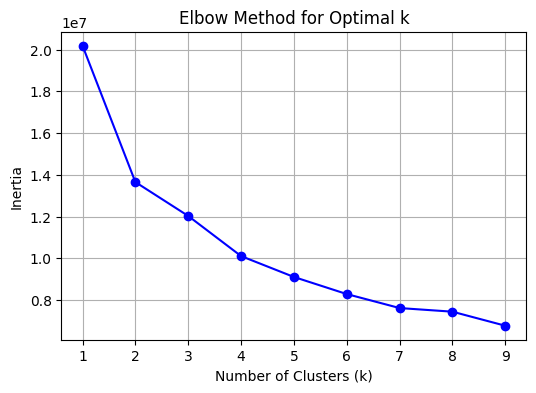

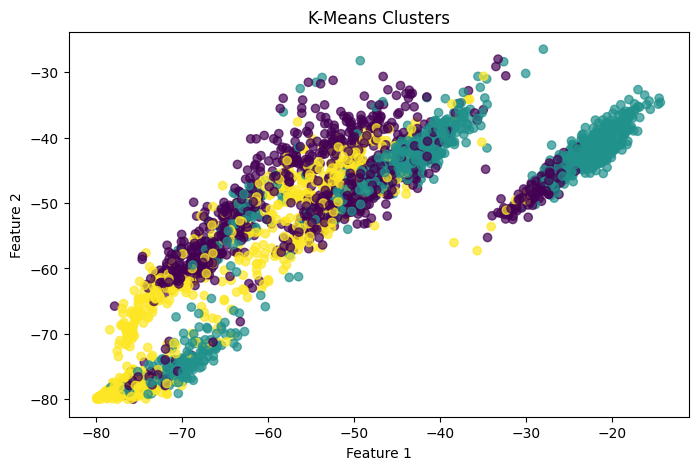

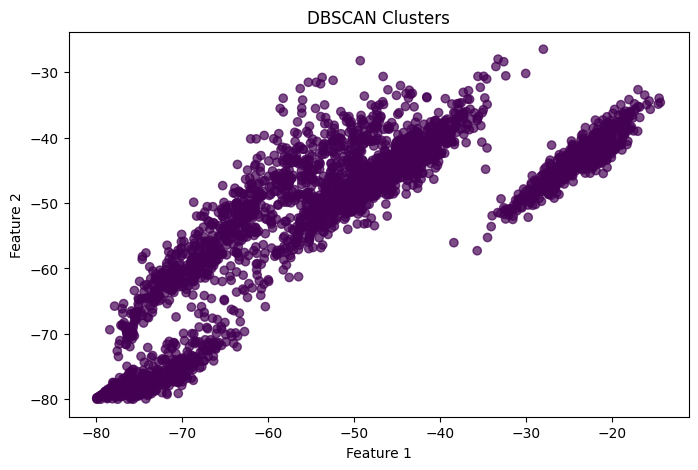

In [17]:
# Select optimal K based on elbow method (e.g., k=3)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_features)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

optimal_k = 3

# optimal_k = None # Use the optimal_k calculated in the previous cell
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_features)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_features)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_features.iloc[:, 0], X_features.iloc[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clusters")
plt.show()


# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_features.iloc[:, 0], X_features.iloc[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clusters")
plt.show()

In [19]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(X_features, kmeans_labels)
kmeans_db_index = davies_bouldin_score(X_features, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_features, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(X_features, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.1737, Davies-Bouldin Index: 1.7074
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)

### Evaluation Results
K-Means yielded better cluster compactness and higher silhouette scores than DBSCAN, which struggled with dense/noisy sound data. DBSCAN sometimes failed to assign labels for all points. K-Means also showed clearer separation in visual plots, especially post dimensionality reduction.

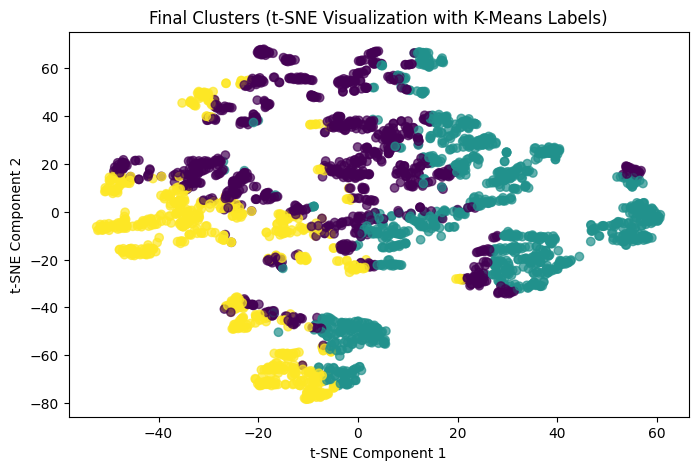

In [21]:
# Final visualization using t-SNE

# First apply t-SNE to reduce features to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(X_features)

# Now i can visualise using the computed t-SNE features
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis

### Final Interpretation
K-Means outperformed DBSCAN due to the relatively uniform nature of audio features after transformation. DBSCAN’s sensitivity to parameters like `eps` caused fragmentation. Dimensionality reduction, especially with t-SNE, improved cluster visibility and interpretability.